# Create Network for Main Path Creation in Pajek


In [2]:
%load_ext autoreload
%autoreload 2

In [66]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from src.network.creation.PajekNetworkCreator import PajekNetworkCreator
from src.network.creation.PajekNetworkCreatorUtils import (
    PajekNetworkCreatorUtils as utils,
)

# show all columns
pd.set_option("display.max_columns", None)

In [67]:
# read in G
p = "../data/05-graphs/citation-graph/directed_citation_graph.graphml"
G_og = nx.read_graphml(p)

# clean graph

- clean attributes
- remove loops by creating familiy nodes (see Liu 2019)
- remove isolates
  extract largest weakly connected component (WCC)


In [68]:
attr_to_keep = ["eid", "unique_auth_year"]
creator = PajekNetworkCreator(G_og, attr_to_keep)
Gpjk, log = creator.prepare_pajek()

print(f"Original number of nodes: {G_og.number_of_nodes()}")
print(f"Original number of edges: {G_og.number_of_edges()}")
print(f"New number of nodes: {Gpjk.number_of_nodes()}")
print(f"New number of edges: {Gpjk.number_of_edges()}")

print(f" Removed bc loops: {log['loops_removed']['count']}")
print(f" Removed bc isolates: {log['isolates_removed']['count']}")
print(f" Removed bc largest wcc: {log['largest_wcc_removed']['count']}")

Original number of nodes: 40643
Original number of edges: 360645
New number of nodes: 37587
New number of edges: 358235
 Removed bc loops: 73
 Removed bc isolates: 2778
 Removed bc largest wcc: 153


In [69]:
with open("../output/removal_log/directed_network_info_log_pajek.json", "w") as f:
    json.dump(log, f)

# Resolve family issues

**PROBLEM**: Some large families are built due to updated cochane reviews. They are updated and this creates citation loops and bidirectional citations. This is a problem for the main path analysis.

We solve it the following way:

1. we keep families of up to three members.
2. we keep familiess of greater sizes if they are all published in the same journal issue.
3. Families due to updated cochrane reviews are dissolved by removing edges.
   1. Bidirectional edges are removed, the edge that is going against time is removed.
   2. Other edges that are counterchronological are removed until the cycle is dissolved.


In [70]:
p = "/Users/jlq293/Projects/Study-1-Bibliometrics/data/04-embeddings/df_with_specter2_embeddings.pkl"
df = pd.read_pickle(p)

In [71]:
# Initialize loop_log
loop_log = {
    "nr_of_loops": 0,
    "special_issue_loops": 0,
    "sizes_counts": Counter(),
    "no_special_issue_and_more_than_3": 0,
    "cochrane_update_loops": 0,
}

df_family_dict = {}

for node in Gpjk.nodes(data=True):
    label = node[0]
    if label.startswith("family"):
        # Create loop dataframe
        df_loop = utils.loop_to_df(node, df).reset_index(drop=True)

        # Update loop_log
        loop_log["nr_of_loops"] += 1
        loop_log["sizes_counts"].update([df_loop.shape[0]])

        # Check for special issue
        journals = df_loop["journal"].unique()
        cochrane = any("cochrane" in journal.lower() for journal in journals if journal)
        loop_log["cochrane_update_loops"] += cochrane
        if len(journals) == 1:
            special_issue = True
            loop_log["special_issue_loops"] += 1
        else:
            special_issue = False

        # Check for dissolving condition
        to_dissolve = not len(journals) == 1 and df_loop.shape[0] > 3

        # Store family information
        df_family_dict[label] = {
            "df": df_loop,
            "special_issue": special_issue,
            "to_dissolve": to_dissolve,
        }

# Calculate no_special_issue_and_more_than_3
loop_log["no_special_issue_and_more_than_3"] = sum(
    family_info["to_dissolve"] for family_info in df_family_dict.values()
)

loop_log

{'nr_of_loops': 73,
 'special_issue_loops': 43,
 'sizes_counts': Counter({2: 61, 4: 5, 3: 3, 10: 1, 13: 1, 16: 1, 8: 1}),
 'no_special_issue_and_more_than_3': 7,
 'cochrane_update_loops': 10}

# Take closer look at loops to dissolve


# Families to fix


In [72]:
df_family_dict.keys()

for k, v in df_family_dict.items():
    if v["to_dissolve"]:
        print(k)
        print("-" * 40)

family_Anghelescu_2006_Gastpar_2006_Linde_2009_Szegedi_2005_2
----------------------------------------
family_Brown_2009_2_Pearlstein_2005_Yonkers_2005_Yonkers_2006
----------------------------------------
family_Brown_2014_Carrao_2007_Howes_2020_Hughes_2005_Hughes_2007_2_Hughes_2014_2_Minami_2014_Minami_2015_Spring_2007_VanDerMeer_2013
----------------------------------------
family_Carpenter_2011_Cipriani_2009_3_Cipriani_2009_4_Gibiino_2012_Hetrick_2007_Imperadore_2007_Klinger_2011_Kronenberg_2008_Magni_2013_Omori_2010_Purgato_2014_Schneeweiss_2010_2_Sie_2012
----------------------------------------
family_Asakura_2016_Bandelow_2008_2_Bandelow_2012_Bandelow_2015_Blanco_2013_Book_2008_Davis_2014_Dempsey_2009_Faria_2012_Faria_2014_Nordahl_2016_Phan_2013_Ravindran_2010_Thomas_2008_3_Williams_2017_Yoshinaga_2013
----------------------------------------
family_Ayerbe_2014_He_2018_2_Kraglund_2018_Legg_2019_Mortensen_2015_Mortensen_2015_2_Pan_2018_2_Siepmann_2015_2
-------------------------

In [73]:
# store all edges to remove
edges_to_remove = []

# family_Anghelescu_2006_Gastpar_2006_Linde_2009_Szegedi_2005_2


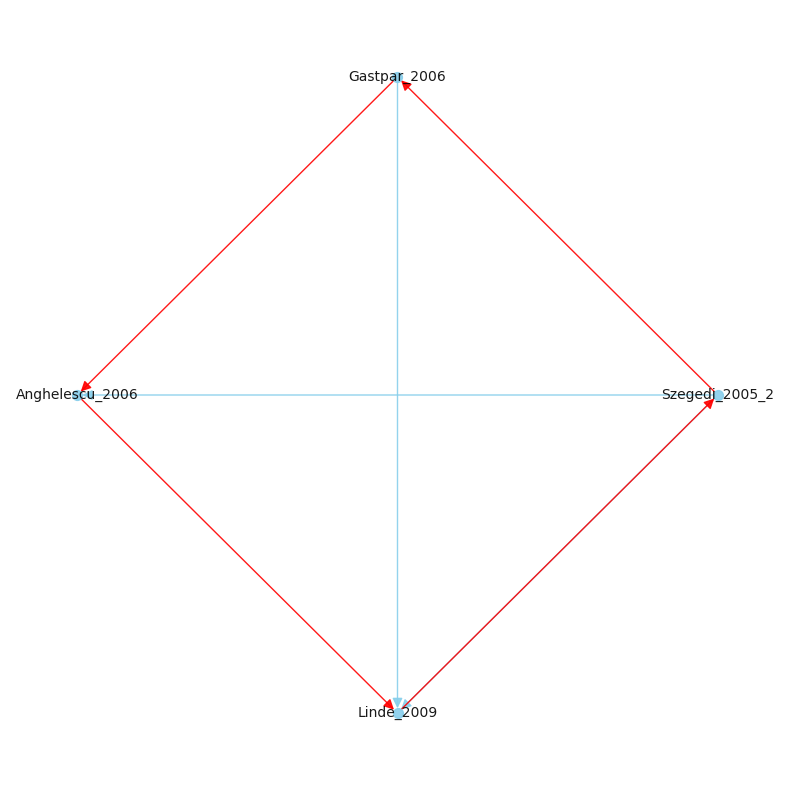

Reverse timed citation edges:
('Szegedi_2005_2', 'Gastpar_2006')
('Szegedi_2005_2', 'Anghelescu_2006')
('Gastpar_2006', 'Linde_2009')
('Anghelescu_2006', 'Linde_2009')
('Szegedi_2005_2', 'Linde_2009')
Cochrane Reviews:  Linde_2009


In [74]:
fam = "family_Anghelescu_2006_Gastpar_2006_Linde_2009_Szegedi_2005_2"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

In [75]:
# remove the edge 'Linde_2009' -> 'Szegedi_2005_2' is a false time loop
print(utils.G_is_a_cycle(G))

G.remove_edge("Linde_2009", "Szegedi_2005_2")
G_og.remove_edge("Linde_2009", "Szegedi_2005_2")

edges_to_remove.append(("Linde_2009", "Szegedi_2005_2"))

print(utils.G_is_a_cycle(G))

True
False


# family_Brown_2009_2_Pearlstein_2005_Yonkers_2005_Yonkers_2006


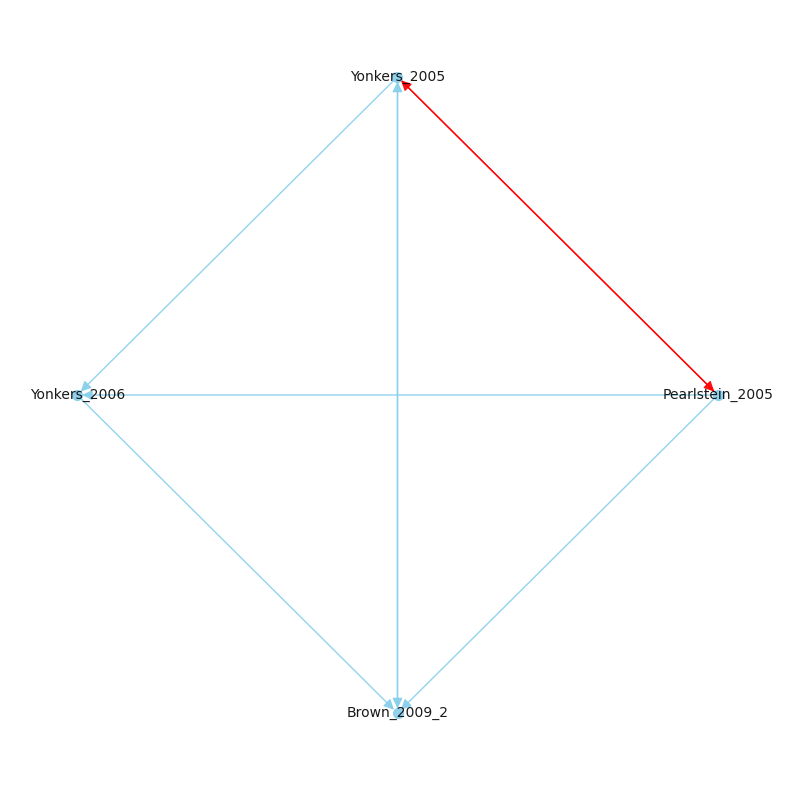

Reverse timed citation edges:
('Yonkers_2005', 'Yonkers_2006')
('Pearlstein_2005', 'Yonkers_2006')
('Yonkers_2005', 'Brown_2009_2')
('Pearlstein_2005', 'Brown_2009_2')
('Yonkers_2006', 'Brown_2009_2')
Cochrane Reviews:  Brown_2009_2


In [13]:
fam = "family_Brown_2009_2_Pearlstein_2005_Yonkers_2005_Yonkers_2006"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

In [76]:
# remove the edge 'Linde_2009' -> 'Szegedi_2005_2' is a false time loop
print(utils.G_is_a_cycle(G))

G.remove_edge("Brown_2009_2", "Yonkers_2005")
G.remove_edge("Pearlstein_2005", "Yonkers_2005")

G_og.remove_edge("Brown_2009_2", "Yonkers_2005")
G_og.remove_edge("Pearlstein_2005", "Yonkers_2005")

edges_to_remove.append(("Brown_2009_2", "Yonkers_2005"))
edges_to_remove.append(("Pearlstein_2005", "Yonkers_2005"))

print(utils.G_is_a_cycle(G))

False


NetworkXError: The edge Brown_2009_2-Yonkers_2005 not in graph.

# family_Brown_2014_Carrao_2007_Howes_2020_Hughes_2005_Hughes_2007_2_Hughes_2014_2_Minami_2014_Minami_2015_Spring_2007_VanDerMeer_2013


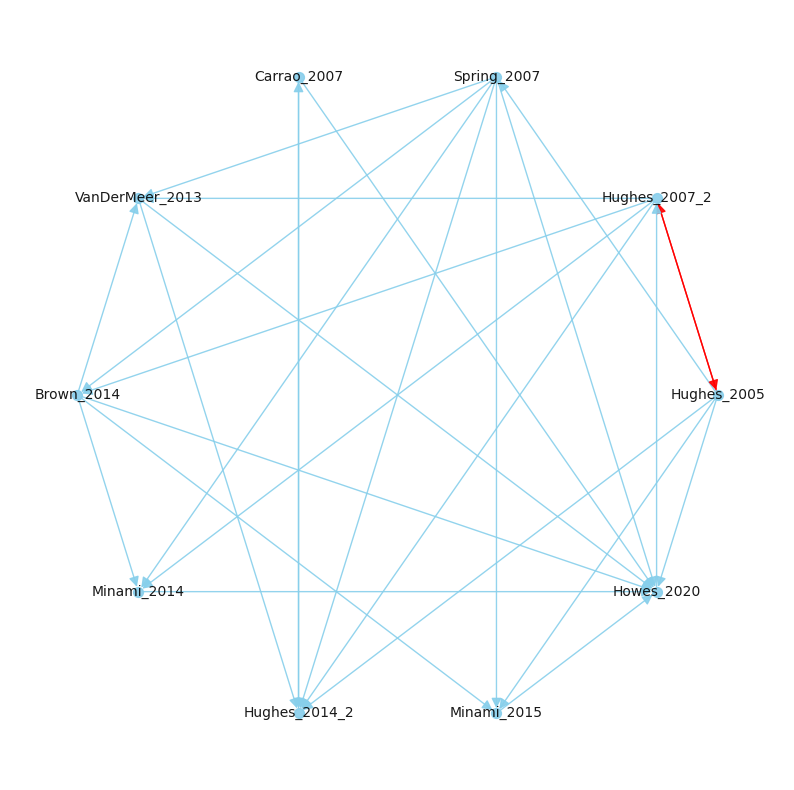

Reverse timed citation edges:
('Hughes_2005', 'Hughes_2007_2')
('Hughes_2005', 'Spring_2007')
('Spring_2007', 'VanDerMeer_2013')
('Hughes_2007_2', 'VanDerMeer_2013')
('Spring_2007', 'Brown_2014')
('Hughes_2007_2', 'Brown_2014')
('Spring_2007', 'Minami_2014')
('Hughes_2007_2', 'Minami_2014')
('Spring_2007', 'Hughes_2014_2')
('Hughes_2007_2', 'Hughes_2014_2')
('Hughes_2005', 'Hughes_2014_2')
('VanDerMeer_2013', 'Hughes_2014_2')
('Carrao_2007', 'Hughes_2014_2')
('Brown_2014', 'Minami_2015')
('Hughes_2005', 'Minami_2015')
('Spring_2007', 'Minami_2015')
('Minami_2014', 'Howes_2020')
('Spring_2007', 'Howes_2020')
('Minami_2015', 'Howes_2020')
('Brown_2014', 'Howes_2020')
('Hughes_2005', 'Howes_2020')
('VanDerMeer_2013', 'Howes_2020')
('Carrao_2007', 'Howes_2020')
Cochrane Reviews:  Hughes_2007_2; VanDerMeer_2013; Hughes_2014_2; Howes_2020


In [15]:
fam = "family_Brown_2014_Carrao_2007_Howes_2020_Hughes_2005_Hughes_2007_2_Hughes_2014_2_Minami_2014_Minami_2015_Spring_2007_VanDerMeer_2013"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

Bidirectional edges removed: 2
Cycle found in the graph


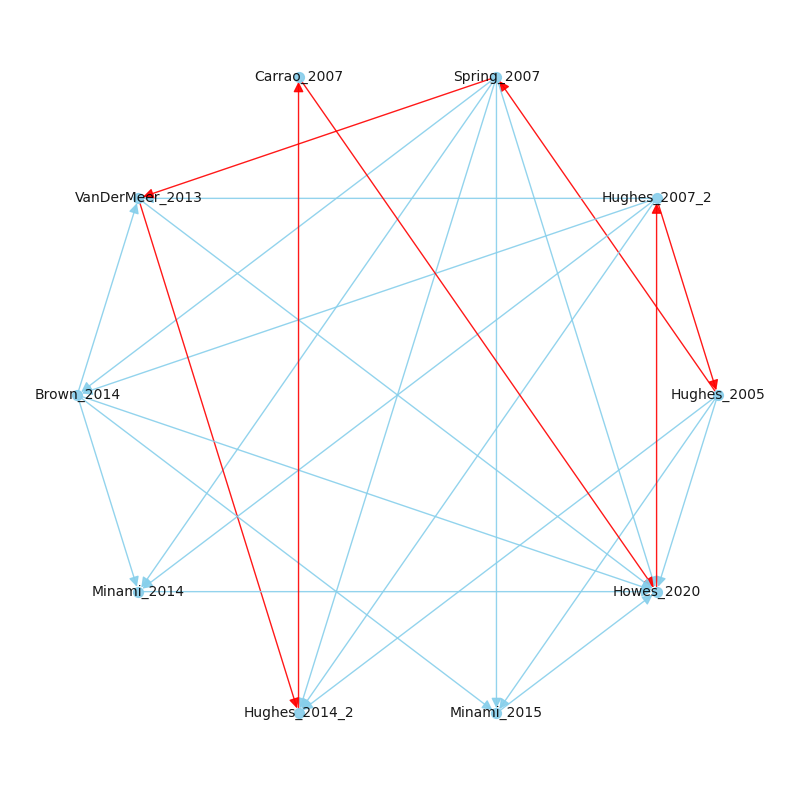

In [16]:
G, bidirectional_edges_removed = utils.remove_reverse_time_bidirectional_edge(G)
print("Bidirectional edges removed:", len(bidirectional_edges_removed))

edges_to_remove.extend(bidirectional_edges_removed)

if utils.G_is_a_cycle(G):
    print("Cycle found in the graph")
    utils.draw_graph(G)

Removed edge Hughes_2005 -> Spring_2007
Removed edge Spring_2007 -> VanDerMeer_2013
Removed edge Hughes_2007_2 -> VanDerMeer_2013
Removed edge Spring_2007 -> Brown_2014
Removed edge Hughes_2007_2 -> Brown_2014
Removed edge Spring_2007 -> Minami_2014
Removed edge Hughes_2007_2 -> Minami_2014
Removed edge Spring_2007 -> Hughes_2014_2
Removed edge Hughes_2007_2 -> Hughes_2014_2
Removed edge Hughes_2005 -> Hughes_2014_2
Removed edge VanDerMeer_2013 -> Hughes_2014_2
Removed edge Brown_2014 -> Minami_2015
Removed edge Hughes_2005 -> Minami_2015
Removed edge Spring_2007 -> Minami_2015
Removed edge Minami_2014 -> Howes_2020
Removed edge Spring_2007 -> Howes_2020
Removed edge Minami_2015 -> Howes_2020
Removed edge Brown_2014 -> Howes_2020
Removed edge Hughes_2005 -> Howes_2020


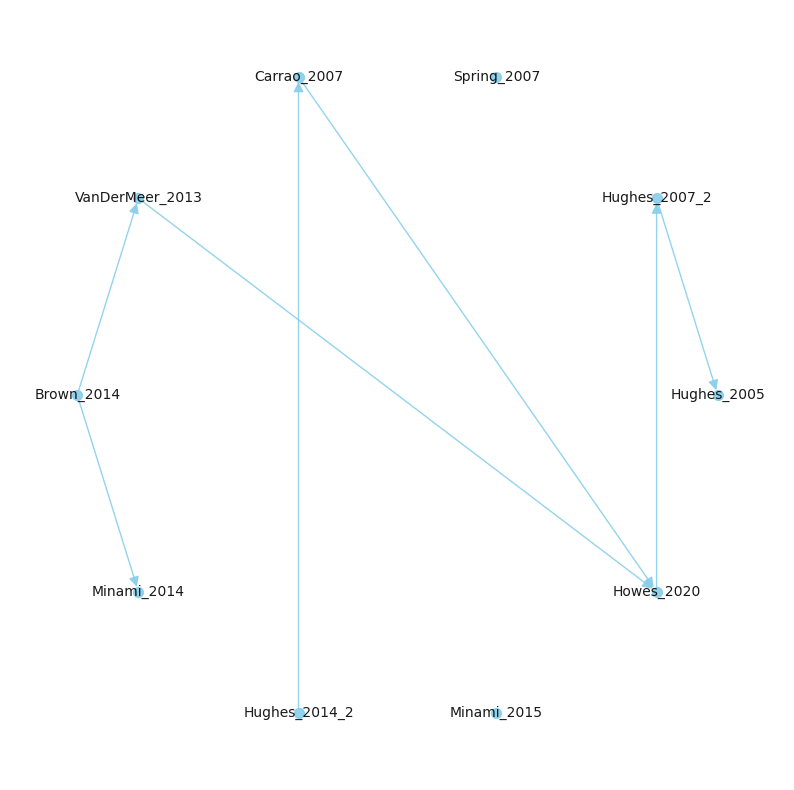

In [17]:
reversed_edges = [
    edge for edge in reversed_edges if edge not in bidirectional_edges_removed
]

for edge in reversed_edges:
    if utils.G_is_a_cycle(G):
        G.remove_edge(edge[0], edge[1])
        print(f"Removed edge {edge[0]} -> {edge[1]}")
        edges_to_remove.append(edge)
    else:
        break

if utils.G_is_a_cycle(G):
    print("No cycle found in the graph")
utils.draw_graph(G)

In [18]:
print(df_fam[df_fam["unique_auth_year"] == "Spring_2007"]["api_url"].values[0])
print(df_fam[df_fam["unique_auth_year"] == "Spring_2007"]["doi"].values[0])

print("Looking at the paper, the citations in Scopus seem to be false")

https://api.elsevier.com/content/abstract/scopus_id/33846984990
10.1037/0022-006X.75.1.85
Looking at the paper, the citations in Scopus seem to be false


In [19]:
print(df_fam[df_fam["unique_auth_year"] == "Minami_2015"]["api_url"].values[0])
print(df_fam[df_fam["unique_auth_year"] == "Minami_2015"]["doi"].values[0])

print(
    "Looking at the paper, the citations in Scopus seem to be false (minami does not cite howes 2020)"
)

https://api.elsevier.com/content/abstract/scopus_id/84924202566
10.1097/ADT.0000000000000042
Looking at the paper, the citations in Scopus seem to be false (minami does not cite howes 2020)


# family_Carpenter_2011_Cipriani_2009_3_Cipriani_2009_4_Gibiino_2012_Hetrick_2007_Imperadore_2007_Klinger_2011_Kronenberg_2008_Magni_2013_Omori_2010_Purgato_2014_Schneeweiss_2010_2_Sie_2012


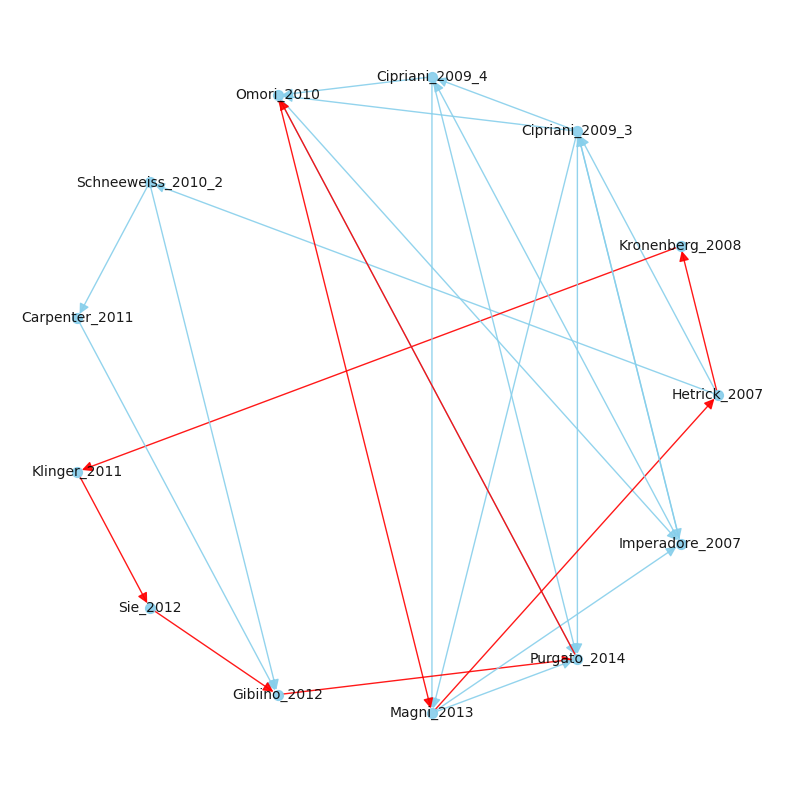

Reverse timed citation edges:
('Hetrick_2007', 'Kronenberg_2008')
('Imperadore_2007', 'Cipriani_2009_3')
('Hetrick_2007', 'Cipriani_2009_3')
('Imperadore_2007', 'Cipriani_2009_4')
('Cipriani_2009_4', 'Omori_2010')
('Cipriani_2009_3', 'Omori_2010')
('Hetrick_2007', 'Schneeweiss_2010_2')
('Schneeweiss_2010_2', 'Carpenter_2011')
('Kronenberg_2008', 'Klinger_2011')
('Klinger_2011', 'Sie_2012')
('Schneeweiss_2010_2', 'Gibiino_2012')
('Carpenter_2011', 'Gibiino_2012')
('Cipriani_2009_4', 'Magni_2013')
('Omori_2010', 'Magni_2013')
('Cipriani_2009_3', 'Magni_2013')
('Cipriani_2009_4', 'Purgato_2014')
('Gibiino_2012', 'Purgato_2014')
('Magni_2013', 'Purgato_2014')
('Omori_2010', 'Purgato_2014')
('Cipriani_2009_3', 'Purgato_2014')
Cochrane Reviews:  Hetrick_2007; Cipriani_2009_3; Cipriani_2009_4; Omori_2010; Magni_2013; Purgato_2014; Imperadore_2007


In [20]:
fam = "family_Carpenter_2011_Cipriani_2009_3_Cipriani_2009_4_Gibiino_2012_Hetrick_2007_Imperadore_2007_Klinger_2011_Kronenberg_2008_Magni_2013_Omori_2010_Purgato_2014_Schneeweiss_2010_2_Sie_2012"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

Bidirectional edges removed: 2
Cycle found in the graph


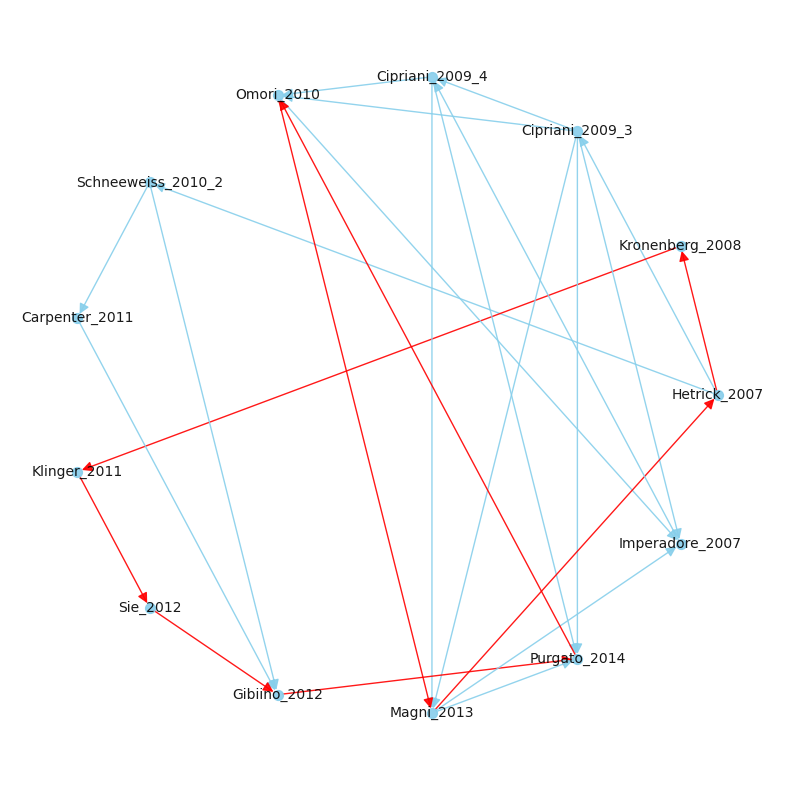

In [21]:
G, bidirectional_edges_removed = utils.remove_reverse_time_bidirectional_edge(G)
print("Bidirectional edges removed:", len(bidirectional_edges_removed))

edges_to_remove.extend(bidirectional_edges_removed)

if utils.G_is_a_cycle(G):
    print("Cycle found in the graph")
    utils.draw_graph(G)

Removed edge Hetrick_2007 -> Kronenberg_2008
Removed edge Hetrick_2007 -> Cipriani_2009_3
Removed edge Imperadore_2007 -> Cipriani_2009_4
Removed edge Cipriani_2009_4 -> Omori_2010
Removed edge Cipriani_2009_3 -> Omori_2010
Removed edge Hetrick_2007 -> Schneeweiss_2010_2
Removed edge Schneeweiss_2010_2 -> Carpenter_2011
Removed edge Kronenberg_2008 -> Klinger_2011
Removed edge Klinger_2011 -> Sie_2012
Removed edge Schneeweiss_2010_2 -> Gibiino_2012
Removed edge Carpenter_2011 -> Gibiino_2012
Removed edge Cipriani_2009_4 -> Magni_2013
Removed edge Omori_2010 -> Magni_2013


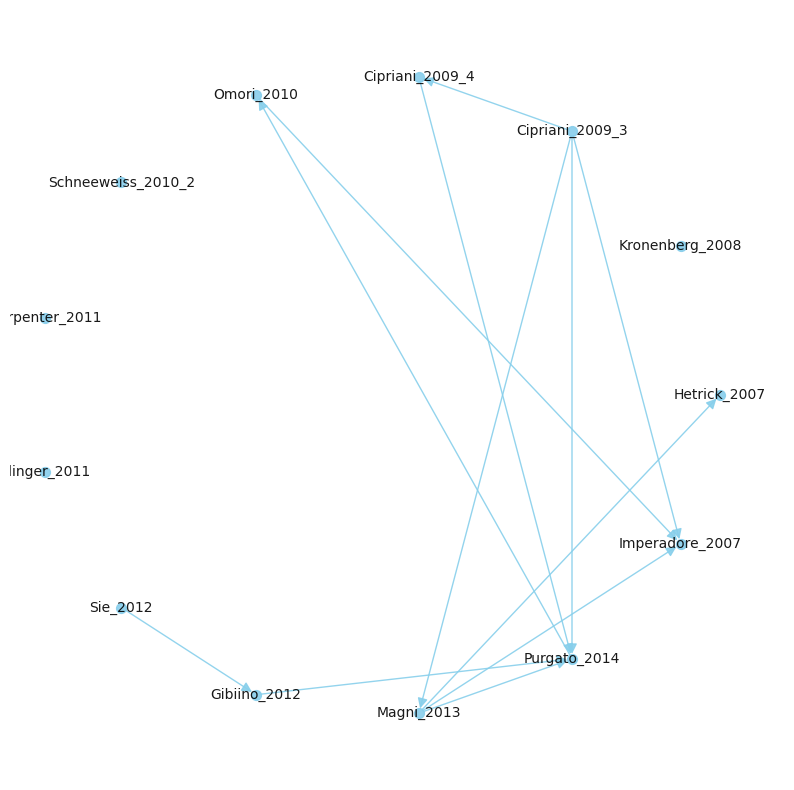

In [22]:
reversed_edges = [
    edge for edge in reversed_edges if edge not in bidirectional_edges_removed
]

for edge in reversed_edges:
    if utils.G_is_a_cycle(G):
        G.remove_edge(edge[0], edge[1])
        print(f"Removed edge {edge[0]} -> {edge[1]}")
        edges_to_remove.append(edge)
    else:
        break

if utils.G_is_a_cycle(G):
    print("No cycle found in the graph")
utils.draw_graph(G)

# family_Asakura_2016_Bandelow_2008_2_Bandelow_2012_Bandelow_2015_Blanco_2013_Book_2008_Davis_2014_Dempsey_2009_Faria_2012_Faria_2014_Nordahl_2016_Phan_2013_Ravindran_2010_Thomas_2008_3_Williams_2017_Yoshinaga_2013


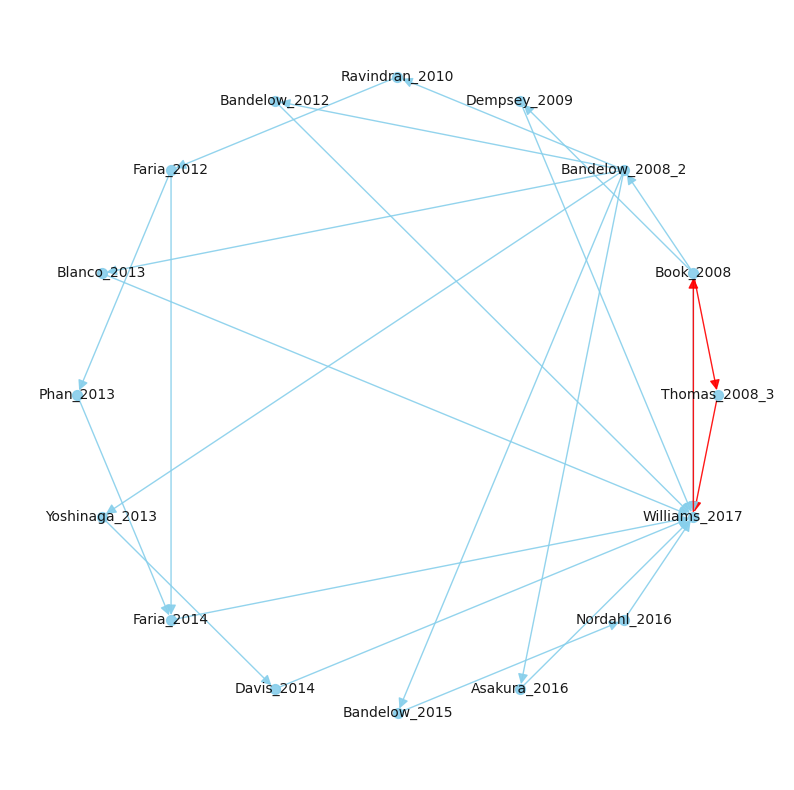

Reverse timed citation edges:
('Book_2008', 'Dempsey_2009')
('Bandelow_2008_2', 'Ravindran_2010')
('Bandelow_2008_2', 'Bandelow_2012')
('Ravindran_2010', 'Faria_2012')
('Bandelow_2008_2', 'Blanco_2013')
('Faria_2012', 'Phan_2013')
('Bandelow_2008_2', 'Yoshinaga_2013')
('Phan_2013', 'Faria_2014')
('Faria_2012', 'Faria_2014')
('Yoshinaga_2013', 'Davis_2014')
('Bandelow_2008_2', 'Bandelow_2015')
('Bandelow_2008_2', 'Asakura_2016')
('Bandelow_2015', 'Nordahl_2016')
('Thomas_2008_3', 'Williams_2017')
('Bandelow_2012', 'Williams_2017')
('Asakura_2016', 'Williams_2017')
('Dempsey_2009', 'Williams_2017')
('Blanco_2013', 'Williams_2017')
('Book_2008', 'Williams_2017')
('Davis_2014', 'Williams_2017')
('Faria_2014', 'Williams_2017')
('Nordahl_2016', 'Williams_2017')
Cochrane Reviews:  Williams_2017


In [23]:
fam = "family_Asakura_2016_Bandelow_2008_2_Bandelow_2012_Bandelow_2015_Blanco_2013_Book_2008_Davis_2014_Dempsey_2009_Faria_2012_Faria_2014_Nordahl_2016_Phan_2013_Ravindran_2010_Thomas_2008_3_Williams_2017_Yoshinaga_2013"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

Bidirectional edges removed: 1
Cycle found in the graph


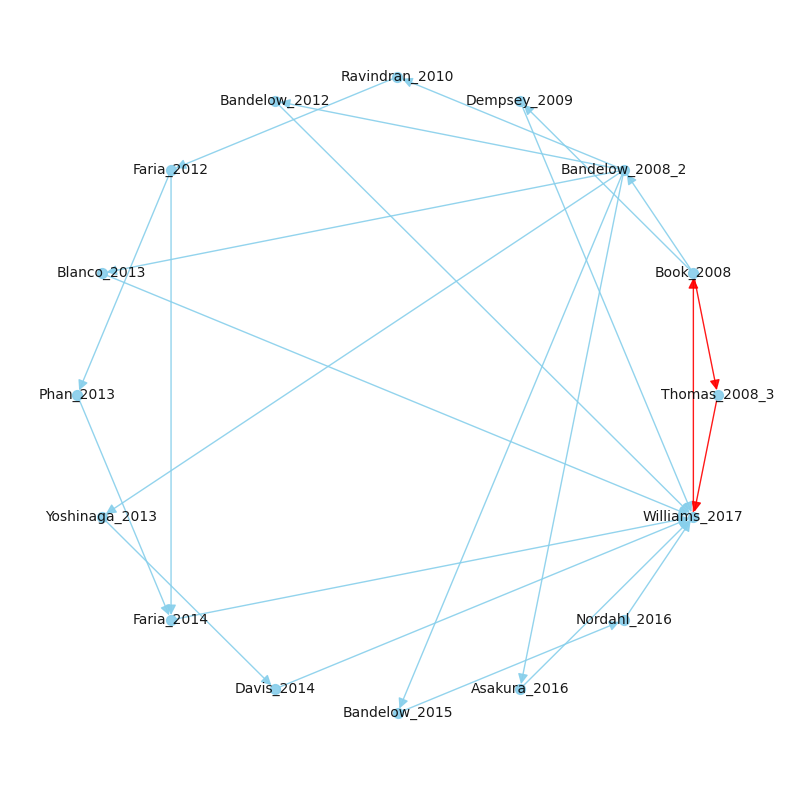

In [24]:
# remove bidirectional edges
G, bidirectional_edges_removed = utils.remove_reverse_time_bidirectional_edge(G)

print("Bidirectional edges removed:", len(bidirectional_edges_removed))

edges_to_remove.extend(bidirectional_edges_removed)

if utils.G_is_a_cycle(G):
    print("Cycle found in the graph")
    utils.draw_graph(G)

Removed edge Book_2008 -> Dempsey_2009
Removed edge Bandelow_2008_2 -> Ravindran_2010
Removed edge Bandelow_2008_2 -> Bandelow_2012
Removed edge Ravindran_2010 -> Faria_2012
Removed edge Bandelow_2008_2 -> Blanco_2013
Removed edge Faria_2012 -> Phan_2013
Removed edge Bandelow_2008_2 -> Yoshinaga_2013
Removed edge Phan_2013 -> Faria_2014
Removed edge Faria_2012 -> Faria_2014
Removed edge Yoshinaga_2013 -> Davis_2014
Removed edge Bandelow_2008_2 -> Bandelow_2015
Removed edge Bandelow_2008_2 -> Asakura_2016
Removed edge Bandelow_2015 -> Nordahl_2016
Removed edge Thomas_2008_3 -> Williams_2017


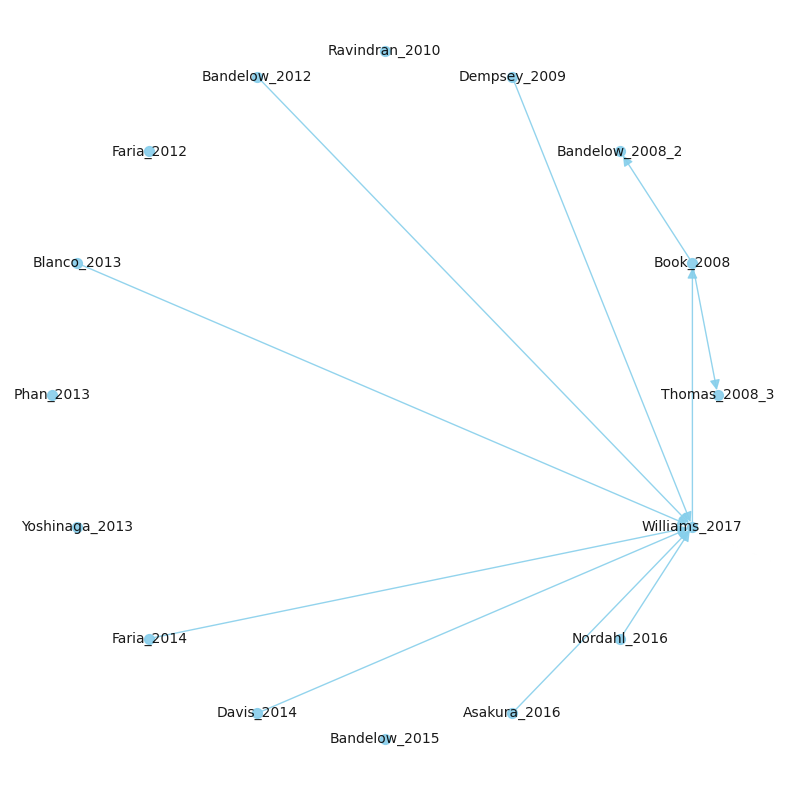

In [25]:
reversed_edges = [
    edge for edge in reversed_edges if edge not in bidirectional_edges_removed
]

for edge in reversed_edges:
    if utils.G_is_a_cycle(G):
        G.remove_edge(edge[0], edge[1])
        print(f"Removed edge {edge[0]} -> {edge[1]}")
        edges_to_remove.append(edge)
    else:
        break

if utils.G_is_a_cycle(G):
    print("No cycle found in the graph")
utils.draw_graph(G)

In [26]:
print(df_fam[df_fam["unique_auth_year"] == "Williams_2017"]["api_url"].values[0])
print(df_fam[df_fam["unique_auth_year"] == "Williams_2017"]["doi"].values[0])

https://api.elsevier.com/content/abstract/scopus_id/85032856752
10.1002/14651858.CD001206.pub3


# family_Ayerbe_2014_He_2018_2_Kraglund_2018_Legg_2019_Mortensen_2015_Mortensen_2015_2_Pan_2018_2_Siepmann_2015_2


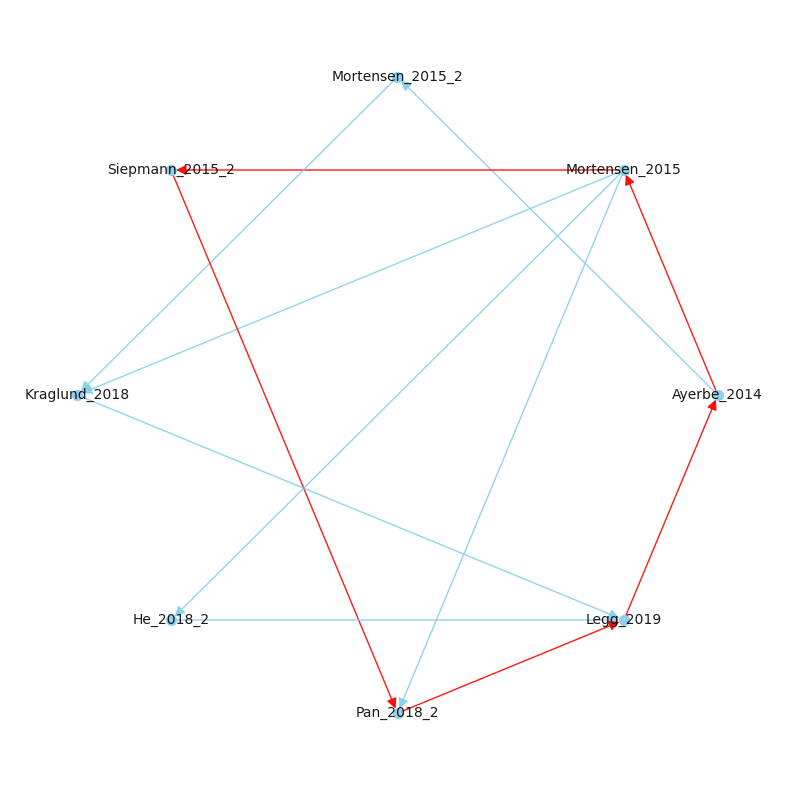

Reverse timed citation edges:
('Ayerbe_2014', 'Mortensen_2015')
('Ayerbe_2014', 'Mortensen_2015_2')
('Mortensen_2015_2', 'Kraglund_2018')
('Mortensen_2015', 'Kraglund_2018')
('Mortensen_2015', 'He_2018_2')
('Siepmann_2015_2', 'Pan_2018_2')
('Mortensen_2015', 'Pan_2018_2')
('He_2018_2', 'Legg_2019')
('Kraglund_2018', 'Legg_2019')
('Pan_2018_2', 'Legg_2019')
Cochrane Reviews:  Legg_2019


In [27]:
fam = "family_Ayerbe_2014_He_2018_2_Kraglund_2018_Legg_2019_Mortensen_2015_Mortensen_2015_2_Pan_2018_2_Siepmann_2015_2"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

Bidirectional edges removed: 0
Cycle found in the graph


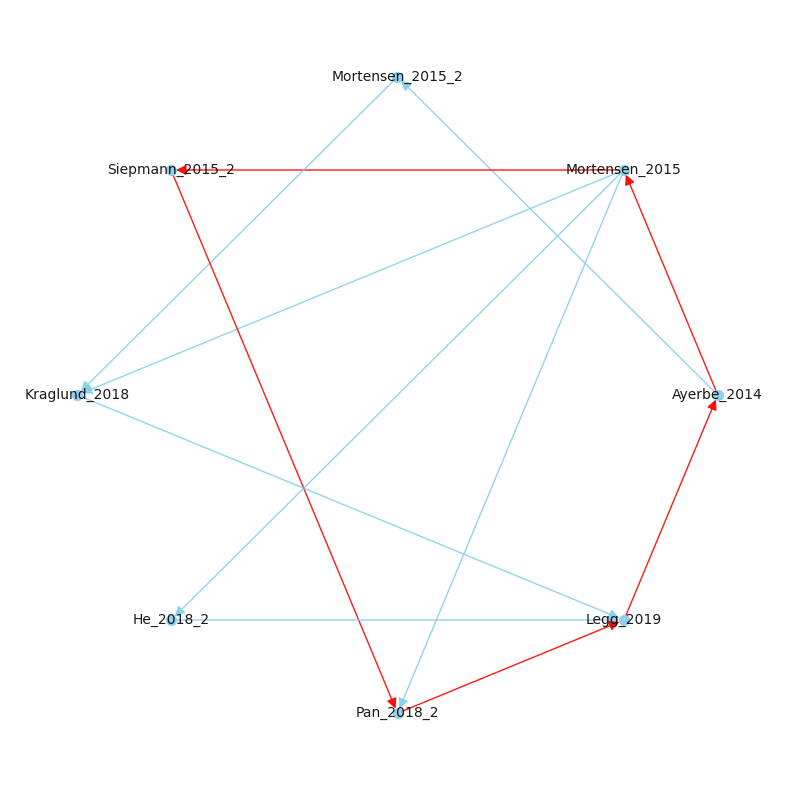

In [28]:
# remove bidirectional edges
G, bidirectional_edges_removed = utils.remove_reverse_time_bidirectional_edge(G)

print("Bidirectional edges removed:", len(bidirectional_edges_removed))
edges_to_remove.extend(bidirectional_edges_removed)

if utils.G_is_a_cycle(G):
    print("Cycle found in the graph")
    utils.draw_graph(G)

Removed edge Ayerbe_2014 -> Mortensen_2015
Removed edge Ayerbe_2014 -> Mortensen_2015_2


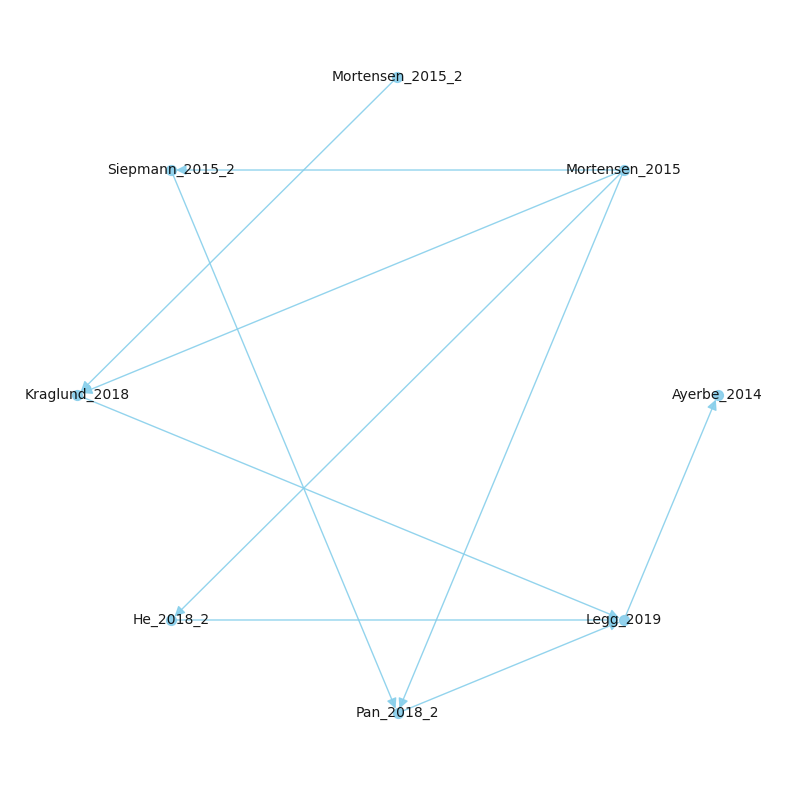

In [29]:
reversed_edges = [
    edge for edge in reversed_edges if edge not in bidirectional_edges_removed
]

for edge in reversed_edges:
    if utils.G_is_a_cycle(G):
        G.remove_edge(edge[0], edge[1])
        print(f"Removed edge {edge[0]} -> {edge[1]}")
        edges_to_remove.append(edge)
    else:
        break

if utils.G_is_a_cycle(G):
    print("No cycle found in the graph")
utils.draw_graph(G)

# family_Ayerbe_2015_Legg_2021_MarquezRomero_2020_Yeo_2017


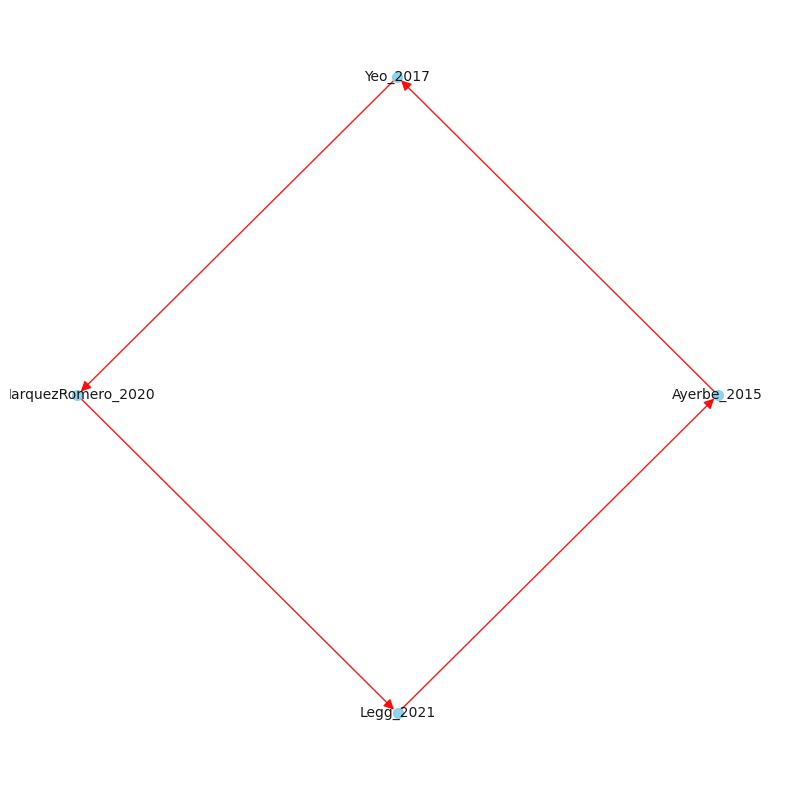

Reverse timed citation edges:
('Ayerbe_2015', 'Yeo_2017')
('Yeo_2017', 'MarquezRomero_2020')
('MarquezRomero_2020', 'Legg_2021')
Cochrane Reviews:  Legg_2021


In [30]:
fam = "family_Ayerbe_2015_Legg_2021_MarquezRomero_2020_Yeo_2017"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

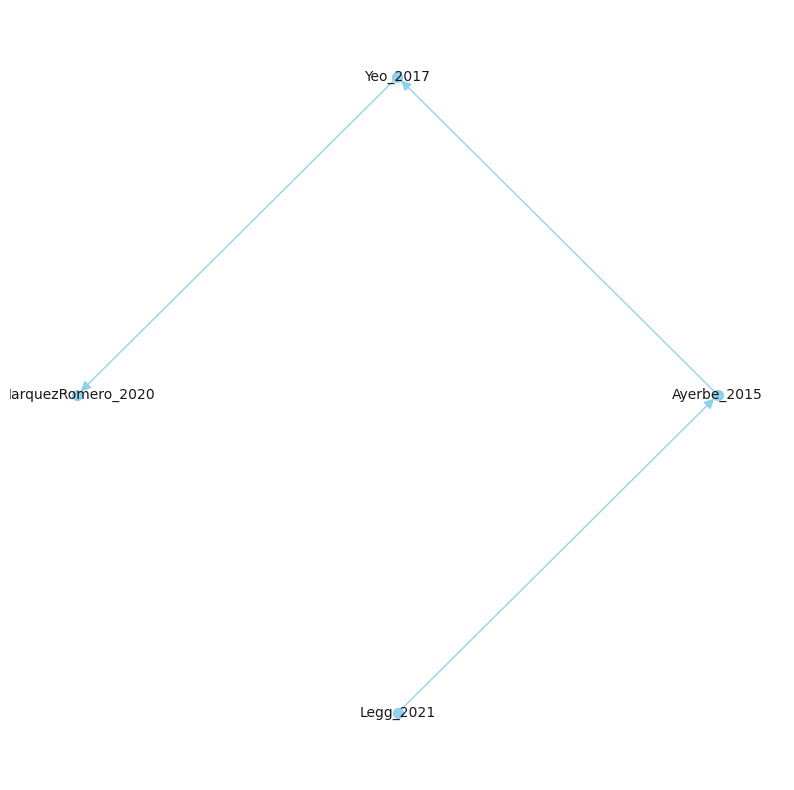

In [31]:
# remove edge  ('MarquezRomero_2020', 'Legg_2021')
G.remove_edge("MarquezRomero_2020", "Legg_2021")

edges_to_remove.append(("MarquezRomero_2020", "Legg_2021"))

if utils.G_is_a_cycle(G):
    print("Cycle found in the graph")
utils.draw_graph(G)

# Remove the edges from the dataframe and build network anew


In [50]:
# read in G
p = "../data/05-graphs/citation-graph/directed_citation_graph.graphml"
G_og = nx.read_graphml(p)

In [51]:
len(edges_to_remove)

57

In [52]:
removed = 0
not_removed = 0
for edge in edges_to_remove:
    try:
        G_og.remove_edge(edge[0], edge[1])
        print(f"Removed edge {edge[0]} -> {edge[1]}")
        removed += 1
    except:
        # print(f"Edge {edge[0]} -> {edge[1]} not found")
        not_removed += 1
print(f"Removed {removed} edges")
print(f"Could not remove {not_removed} edges")

Removed edge Linde_2009 -> Szegedi_2005_2
Removed edge Brown_2009_2 -> Yonkers_2005
Removed edge Pearlstein_2005 -> Yonkers_2005
Removed edge Hughes_2005 -> Hughes_2007_2
Removed edge Carrao_2007 -> Hughes_2014_2
Removed edge Omori_2010 -> Purgato_2014
Removed edge Imperadore_2007 -> Cipriani_2009_3
Removed edge Book_2008 -> Williams_2017
Removed 8 edges
Could not remove 49 edges


In [61]:
G_og.remove_edge("Book_2008", "Dempsey_2009")

NetworkXError: The edge Book_2008-Dempsey_2009 not in graph.

In [63]:
eidies = df[df["unique_auth_year"] == "Book_2008"]["filtered_reference_eids"].values[0]

for eid in eidies:
    print(df[df["eid"] == eid]["unique_auth_year"].values[0])

Randall_2001
Baldwin_1999
Williams_2017
Stein_1998_3
Liebowitz_2005


create families again


In [54]:
attr_to_keep = ["eid", "unique_auth_year"]
creator = PajekNetworkCreator(G_og, attr_to_keep)
Gpjk, log = creator.prepare_pajek()

# Initialize loop_log
loop_log = {
    "nr_of_loops": 0,
    "special_issue_loops": 0,
    "sizes_counts": Counter(),
    "no_special_issue_and_more_than_3": 0,
    "cochrane_update_loops": 0,
}

df_family_dict = {}

for node in Gpjk.nodes(data=True):
    label = node[0]
    if label.startswith("family"):
        # Create loop dataframe
        df_loop = utils.loop_to_df(node, df).reset_index(drop=True)

        # Update loop_log
        loop_log["nr_of_loops"] += 1
        loop_log["sizes_counts"].update([df_loop.shape[0]])

        # Check for special issue
        journals = df_loop["journal"].unique()
        cochrane = any("cochrane" in journal.lower() for journal in journals if journal)
        loop_log["cochrane_update_loops"] += cochrane
        if len(journals) == 1:
            special_issue = True
            loop_log["special_issue_loops"] += 1
        else:
            special_issue = False

        # Check for dissolving condition
        to_dissolve = not len(journals) == 1 and df_loop.shape[0] > 3

        # Store family information
        df_family_dict[label] = {
            "df": df_loop,
            "special_issue": special_issue,
            "to_dissolve": to_dissolve,
        }

# Calculate no_special_issue_and_more_than_3
loop_log["no_special_issue_and_more_than_3"] = sum(
    family_info["to_dissolve"] for family_info in df_family_dict.values()
)

loop_log

{'nr_of_loops': 72,
 'special_issue_loops': 44,
 'sizes_counts': Counter({2: 61, 4: 4, 3: 4, 6: 2, 8: 1}),
 'no_special_issue_and_more_than_3': 4,
 'cochrane_update_loops': 9}